# Modular

- `data_setup.py`: a file to prepare and download data if needed.
- `engine.py`: a file containing various training functions.
- `model_builder.py`: a file to create a Pytorch model.
- `train.py`: a file to leverage all other files and train a target Pytorch model.
- `utils.py`: a file dedicated to helpful utility functions.

## Jupyter notebooks vs Python scripts
- Jupyter notebooks
> 가볍게 데이터를 확인하거나, 새로운 것을 학습(공부)할 때 사용하기 좋음
- Python scripts
> 서비스(상품)을 만들 때, 사용하기 좋음

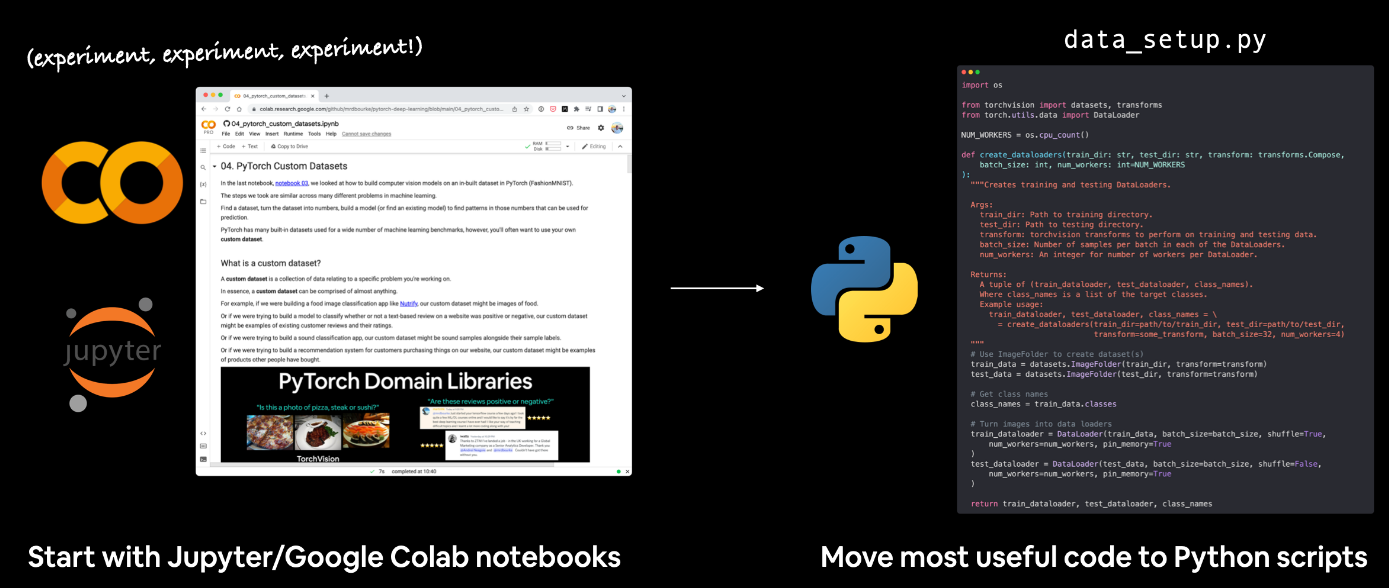

아래와 같이 일반적으로 인터넷에서 Pytorch ML project를 실행시키는 예제 코드이다.

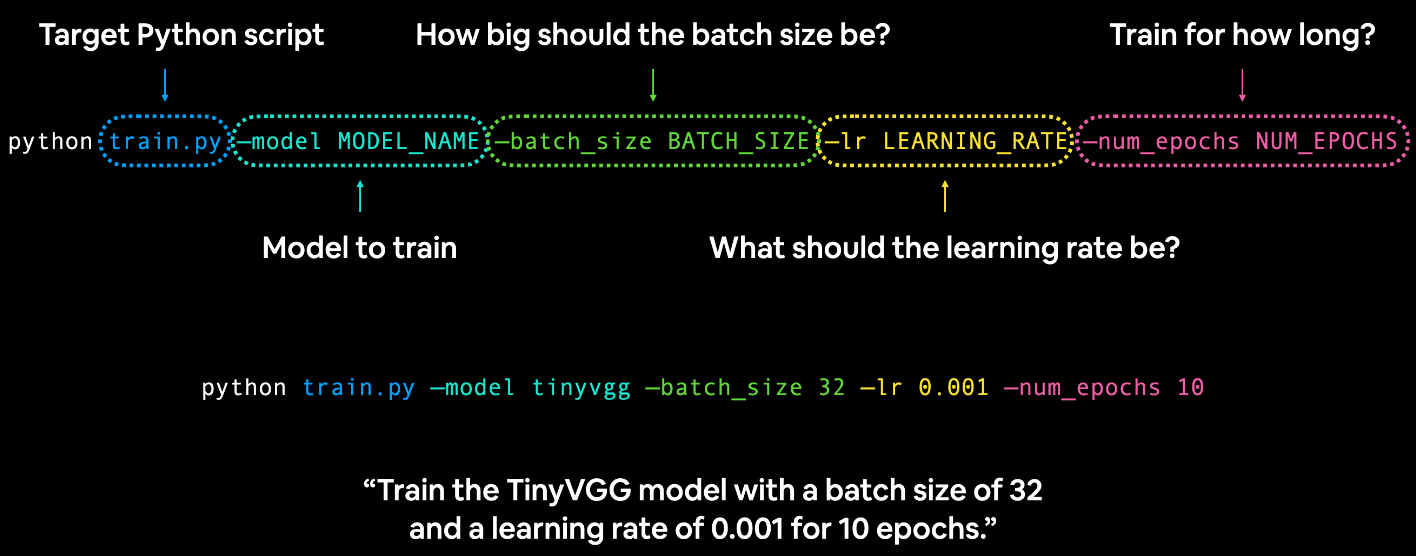

# A directory structure of usable Python scripts

1. learning_modular 폴더 생성
2. learning_modular로 이동
3. service 폴더 생성
4. models 폴더 생성성


주피터 노트북에서 폴더 생성하는 방법
```python
import os

for directory in ['service', 'models']:
    if not os.path.exists(directory):
        os.makedirs(directory)
```

In [ ]:
import os

for directory in ['service', 'models']:
    if not os.path.exists(directory):
        os.makedirs(directory)

```python

learning_modular/ # 프로젝트 최상의 폴더
├── service/
│   ├── data_setup.py
│   ├── engine.py
│   ├── model_builder.py
│   ├── train.py
│   └── utils.py
├── models/
│   ├── LearningModular.pth
└── data/
    └── pizza_steak_sushi/
        ├── train/
        │   ├── pizza/
        │   │   ├── image01.jpeg
        │   │   └── ...
        │   ├── steak/
        │   └── sushi/
        └── test/
            ├── pizza/
            ├── steak/
            └── sushi/

```

# 1.Datasets and DataLoaders(`data_setup.py`)

In [ ]:
%%writefile service/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os
import requests
import zipfile
from pathlib import Path

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

#############################################
# Load Data 함수
#############################################
def load_data():
  # Setup path to data folder
  data_path = Path("data/")
  image_path = data_path / "pizza_steak_sushi" # data/pizza_steak_sushi

  # If the image folder doesn't exist, download it and prepare it...
  if image_path.is_dir():
      print(f"{image_path} directory exists.")
  else:
      print(f"Did not find {image_path} directory, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

      # Download pizza, steak, sushi data
      with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
          request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
          print("Downloading pizza, steak, sushi data...")
          f.write(request.content)

      # Unzip pizza, steak, sushi data
      with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
          print("Unzipping pizza, steak, sushi data...")
          zip_ref.extractall(image_path)

  return str(image_path)

#############################################
# Make DataLoader 함수
#############################################
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing service/data_setup.py


In [ ]:
# Import data_setup.py
from service import data_setup
from service.data_setup import create_dataloaders, NUM_WORKERS
from service.data_setup import *

# 2.Making a model(`model_builder.py`)

In [ ]:
%%writefile service/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


Writing service/model_builder.py


In [ ]:
import torch
# Import model_builder.py
from service import model_builder

import service.model_builder
from service.model_builder import TinyVGG

# 3.Create a file of `engine.py`

1 `train_step()`: takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.    
2 `test_step()`: takes in a model, a `DataLoader` and loss function and evaluates the model on the `DataLoader`.    
3 `train()`: performs 1. and 2. together for a given number of epochs and returns a results dictionary

In [ ]:
%%writefile service/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results


Writing service/engine.py


In [ ]:
from service import engine

# 4.Creating a function to save the model(`utils.py`)

In [ ]:
%%writefile service/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)


Writing service/utils.py


In [ ]:
# Import utils.py
from service import utils

# 5.Train, Evaluate and Save the model(`train.py`)
> run.py, main.py, app.py 등

In [ ]:
%%writefile service/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import sys
import argparse
import data_setup, engine, model_builder, utils

from torchvision import transforms


if __name__ == "__main__":
  # Setup hyperparameters
  NUM_EPOCHS = 5
  BATCH_SIZE = 32
  HIDDEN_UNITS = 10
  LEARNING_RATE = 0.001
  MODEL_NAME = 'LearningModular.pth'

  print('-'*50)
  parser = argparse.ArgumentParser()
  parser.add_argument("--model_name", default="LearningModular.pth")
  parser.add_argument("--batch_size", default=32, type=int)
  parser.add_argument("--lr", default=0.001, type=float)
  parser.add_argument("--num_epochs", default=5, type=int)
  parser.add_argument("--hidden_units", default=10, type=int)
  args = parser.parse_args()

  print(f'NUM_EPOCHS: {args.num_epochs} / BATCH_SIZE: {args.batch_size}')
  print('-'*50)

  # Setup directories
  default_path = data_setup.load_data()
  train_dir = default_path+"/train"
  test_dir = default_path+"/test"

  # Setup target device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Create transforms
  data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
  ])

  # Create DataLoaders with help from data_setup.py
  train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
      train_dir=train_dir,
      test_dir=test_dir,
      transform=data_transform,
      batch_size=args.batch_size
  )

  # Create model with help from model_builder.py
  model = model_builder.TinyVGG(
      input_shape=3,
      hidden_units=args.hidden_units,
      output_shape=len(class_names)
  ).to(device)

  # Set loss and optimizer
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),
                              lr=args.lr)

  # Start training with help from engine.py
  engine.train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              epochs=args.num_epochs,
              device=device)

  # Save the model with help from utils.py
  utils.save_model(model=model,
                  target_dir="models",
                  model_name=args.model_name)


Writing service/train.py


# Run the modular

In [ ]:
!python service/train.py

--------------------------------------------------
NUM_EPOCHS: 5 / BATCH_SIZE: 32
--------------------------------------------------
data/pizza_steak_sushi directory exists.
  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.0936 | train_acc: 0.4219 | test_loss: 1.1160 | test_acc: 0.3598
 20% 1/5 [00:06<00:24,  6.06s/it]Epoch: 2 | train_loss: 1.1098 | train_acc: 0.3047 | test_loss: 1.1103 | test_acc: 0.3400
 40% 2/5 [00:11<00:16,  5.43s/it]Epoch: 3 | train_loss: 1.0946 | train_acc: 0.4258 | test_loss: 1.1144 | test_acc: 0.3598
 60% 3/5 [00:17<00:11,  5.68s/it]Epoch: 4 | train_loss: 1.0947 | train_acc: 0.3047 | test_loss: 1.1060 | test_acc: 0.3400
 80% 4/5 [00:19<00:04,  4.58s/it]Epoch: 5 | train_loss: 1.1086 | train_acc: 0.3867 | test_loss: 1.1097 | test_acc: 0.3305
100% 5/5 [00:22<00:00,  4.43s/it]
[INFO] Saving model to: models/LearningModular.pth


In [ ]:
!python service/train.py --model_name 'Learning_Modular_1.pth' --batch_size 32 --num_epochs 10

--------------------------------------------------
NUM_EPOCHS: 10 / BATCH_SIZE: 32
--------------------------------------------------
data/pizza_steak_sushi directory exists.
  0% 0/10 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.1000 | train_acc: 0.4141 | test_loss: 1.1060 | test_acc: 0.2377
 10% 1/10 [00:02<00:23,  2.64s/it]Epoch: 2 | train_loss: 1.1056 | train_acc: 0.2930 | test_loss: 1.1083 | test_acc: 0.2775
 20% 2/10 [00:05<00:23,  2.94s/it]Epoch: 3 | train_loss: 1.0928 | train_acc: 0.4141 | test_loss: 1.1145 | test_acc: 0.2576
 30% 3/10 [00:07<00:18,  2.60s/it]Epoch: 4 | train_loss: 1.1079 | train_acc: 0.2930 | test_loss: 1.1116 | test_acc: 0.2576
 40% 4/10 [00:10<00:14,  2.44s/it]Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4336 | test_loss: 1.0888 | test_acc: 0.4536
 50% 5/10 [00:12<00:11,  2.36s/it]Epoch: 6 | train_loss: 1.0922 | train_acc: 0.3555 | test_loss: 1.0725 | test_acc: 0.4848
 60% 6/10 [00:14<00:09,  2.32s/it]Epoch: 7 | train_loss: 1.0859 | train_acc: 0.4258 | test_loss